In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Подготовка

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

In [ ]:
import albumentations as albu
import copy
import cv2
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [ ]:
rand = 51
np.random.seed(rand)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [ ]:
gc.collect()

# Основные классы и функции

In [ ]:
class Dataset(data.Dataset):
  def __init__(self, X, y, augmentations=None):
    X = X.reshape(-1, 1, X.shape[1], X.shape[2]).astype(np.float32)
    X = (X - X.min())
    X = X / X.max()
        
    self.X = X
    self.y = y
    self.augmentations = augmentations

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, i):
    x_el, y_el = copy.deepcopy(self.X[i]), copy.deepcopy(self.y[i])
    if self.augmentations is not None:
      sample = self.augmentations(image=x_el[0], mask=y_el)
      x_el[0] = sample['image']
      y_el = sample['mask']

    x_el = torch.from_numpy(x_el).to(device)
    y_el = torch.from_numpy(y_el.astype(np.int64)).to(device)

    return x_el, y_el

def get_loader(dataset, batch=64):
  return data.DataLoader(dataset, batch_size=batch)

def prepare_datasets(X, y):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X, y, train_size=0.8, random_state=rand)
  train = Dataset(X_train, y_train, train_transform)
  test = Dataset(X_test, y_test, test_transform)
  return train, test

In [ ]:
class Network:
  def __init__(self, model, loss):
    self.model = model.to(device)
    self.best_model = copy.deepcopy(model)
    self.loss = loss
    self.best_loss = 1e10
    self.optim = torch.optim.Adam(self.model.parameters())
    self.loss_history = []

  def fit(self, data, epochs=50, verbose=False, no_improvements_iter=-1):
    data = get_loader(data)
    no_improvements = 0
    for i in range(epochs):
      total_loss = 0
      for X, y in data:
        pred = self.model(X)
        loss = self.loss(pred, y)
        total_loss += loss.detach().to('cpu').item()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if verbose:
        print(f'Epoch {i}, loss {total_loss}')
      self.loss_history.append(total_loss)

      if total_loss < self.best_loss and not math.isclose(total_loss, self.best_loss):
        self.best_loss = total_loss
        self.best_model = copy.deepcopy(self.model)
        no_improvements = 0
      else:
        no_improvements += 1
        print(f'No improvements for {no_improvements} epochs')

      if no_improvements_iter != -1 and no_improvements >= no_improvements_iter:
        break

    self.model = copy.deepcopy(self.best_model)

  def test(self, data, metric, *args):
    data = get_loader(data)
    size = len(data.dataset)
    num_batches = len(data)
    total_metric = 0.

    with torch.no_grad():
      for X, y in data:
        pred = self.model(X).argmax(1)
        if metric == 'accuracy':
          total_metric += self._accuracy(pred, y)
        elif metric == 'iou':
          total_metric += self._iou(pred, y, args[0])

    if metric == 'accuracy':
      total_metric /= size
    elif metric == 'iou':
      total_metric /= num_batches

    return total_metric

  def _accuracy(self, y_pred, y_true):
    im_size = y_pred.shape[1] * y_pred.shape[2]
    return (y_pred == y_true).type(torch.float).sum().item() / im_size

  def _iou(self, y_pred, y_true, class_label):
    y_pred = y_pred == class_label
    y_true = y_true == class_label
    intersection = y_pred & y_true
    union = y_pred | y_true
    return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [ ]:
def create_network(n_classes):
  return Network(smp.Unet(in_channels=1, classes=n_classes, activation='softmax'),
                 nn.CrossEntropyLoss())

# Аугментации

Ниже можно видеть набор аугментаций, с которыми у меня получилось добиться наилучшего результата.

In [ ]:
train_transform = albu.Compose([
    albu.VerticalFlip(p=0.5),
    albu.OneOf([
    albu.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0.05,
                          p=0.5, border_mode=cv2.BORDER_REPLICATE),
    albu.GridDistortion(distort_limit=0.37, p=0.5)
    ], p=0.3),
    albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), 
])

test_transform = None

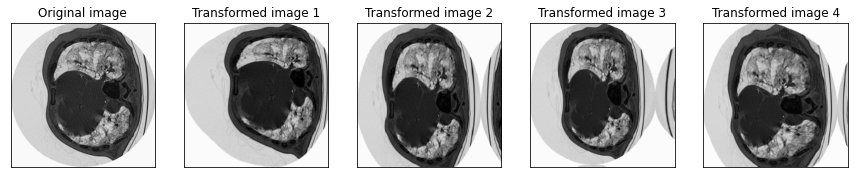

In [ ]:
# Visualize transformations

X = im_medseg[0, 0].reshape((1, 256, 256))
y = mk_medseg[0, 0].reshape((1, 256, 256))

dataset = Dataset(X, y, train_transform)

im_row = X
titles = ['Original image']
for i in range(4):
  x_el, y_el = dataset[0]
  x_el, y_el = x_el.cpu().numpy(), y_el.cpu().numpy()
  im_row = np.vstack((im_row, x_el))
  titles += [f'Transformed image {i+1}']

helpers.show_im_row(im_row, size=3, titles=titles)

# Классифицируем

In [ ]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [ ]:
train, test = prepare_datasets(X, y)
model = create_network(4)

In [ ]:
model.fit(train, epochs=150, verbose=True, no_improvements_iter=5)

Epoch 0, loss 13.833739280700684
Epoch 1, loss 10.56764841079712
Epoch 2, loss 9.639281332492828
Epoch 3, loss 9.395084738731384
Epoch 4, loss 9.31984144449234
Epoch 5, loss 9.286929905414581
Epoch 6, loss 9.265305280685425
Epoch 7, loss 9.255551397800446
Epoch 8, loss 9.244649231433868
Epoch 9, loss 9.216255724430084
Epoch 10, loss 9.195479214191437
Epoch 11, loss 9.165396928787231
Epoch 12, loss 9.158681690692902
Epoch 13, loss 9.139743089675903
Epoch 14, loss 9.134415626525879
Epoch 15, loss 9.126522362232208
Epoch 16, loss 9.126177608966827
Epoch 17, loss 9.120439946651459
Epoch 18, loss 9.120425760746002
Epoch 19, loss 9.118911743164062
Epoch 20, loss 9.116432070732117
Epoch 21, loss 9.109587252140045
Epoch 22, loss 9.107648849487305
Epoch 23, loss 9.107311487197876
Epoch 24, loss 9.099355578422546
Epoch 25, loss 9.100586771965027
No improvements for 1 epochs
Epoch 26, loss 9.102216362953186
No improvements for 2 epochs
Epoch 27, loss 9.099299907684326
Epoch 28, loss 9.09533506631

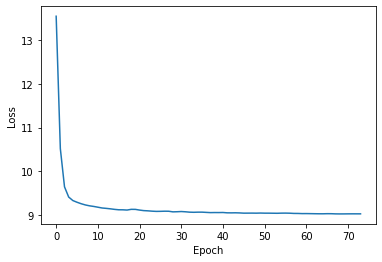

In [ ]:
helpers.plot_loss(model)

In [ ]:
test_report = '{epochs} epochs\nLoss: {loss}\nAccuracy: {accuracy}\n'
accuracy = model.test(test, 'accuracy')
test_report = test_report.format(epochs=len(model.loss_history),
                                 loss=model.best_loss,
                                 accuracy=accuracy)

for i in range(4):
  test_report += f'{helpers.LABELS[i]} IoU: {model.test(test, "iou", i)}\n'

print(test_report)

74 epochs
Loss: 9.026863932609558
Accuracy: 0.9898983534946236
Ground Glass IoU: 0.7004336729537092
Consolidation IoU: 0.5051023906131439
Lungs Other IoU: 0.9447843982706373
Background IoU: 0.994843232074223



Видим, что получилось значительно улучшить результат по сравнению с изначальной моделью.

In [ ]:
label_pairs = [('True ' + label, 'Predicted ' + label)
               for label in helpers.LABELS]
# flatten label pairs
labels = [label for pair in label_pairs for label in pair]

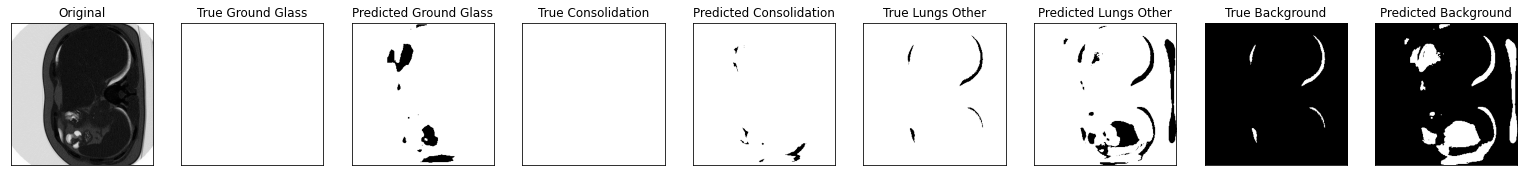

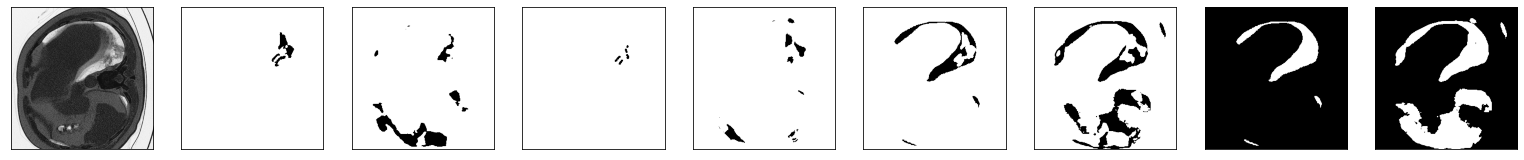

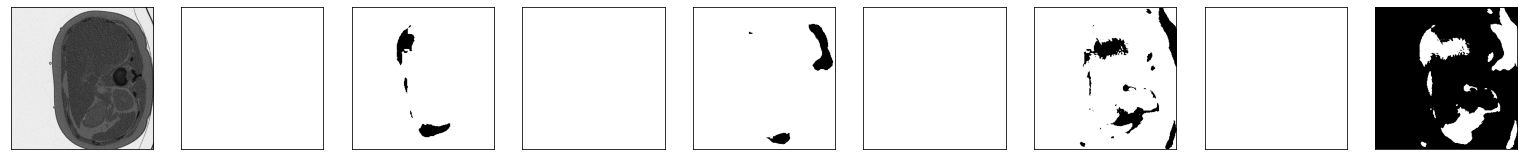

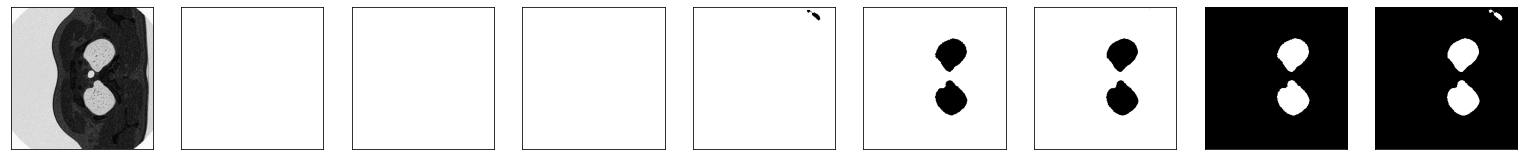

In [ ]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original'] + labels if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)

In [ ]:
torch.save(model.model.state_dict(), path + 'albu-model')
drive.flush_and_unmount()